# Pyem

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
#from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *

In [72]:
from external.pyem.project import project
from external.pyem.pyem import star
from external.pyem.pyem import vop
from numpy.fft import fftshift
from pyfftw.builders import irfft2

In [73]:
# Arguments for project:
# p : dataframe of star file : df = star.parse_star(args.input, keep_index=False); star.augment_star_ucsf(df);
#     Here, input is the STAR file with particle metadata
# 


### The volume

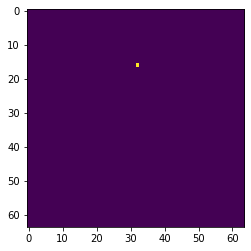

In [74]:
nx = 64
dx = 0.2

v = np.zeros([nx,nx,nx])
v[16,32,32] = 1

mip_z(v)


In [76]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

f3d = vop.vol_ft(v, pfac=1, threads=1)

### Parameters from the star file
https://relion.readthedocs.io/en/release-3.1/Reference/Conventions.html?highlight=star#star-format

In [137]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)

/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [293]:
dfiter = df.iterrows()
i, p = next(dfiter)
#i, p = next(dfiter)

#p["rlnVoltage"] = 0
#p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = 10
p[star.Relion.ORIGINY] = 0

# These don't seem to make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
#p[star.Relion.ORIGINXANGST] = 0
#p[star.Relion.ORIGINXANGST] = 0

p[star.Relion.ANGLEROT] = 90
p[star.Relion.ANGLETILT] = 0
p[star.Relion.ANGLEPSI] = 0


p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

p[star.Relion.DEFOCUSU] = 0
p[star.Relion.DEFOCUSV] = 0
p[star.Relion.DEFOCUSANGLE] = 0

In [294]:
pfac = 1

size = (f3d.shape[0] - 3) // pfac
#size = f3d.shape[0]

sz = (f3d.shape[0] - 3) // pfac
apix = star.calculate_apix(df) * np.double(size) / sz
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)




In [295]:
f2d = project(f3d, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


ift = irfft2(f2d.copy(), threads=1, planner_effort="FFTW_ESTIMATE", auto_align_input=True, auto_contiguous=True)
proj = fftshift(ift(f2d.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype)))

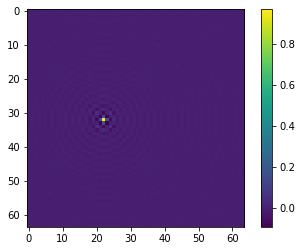

In [296]:
plt.imshow(proj); plt.colorbar()

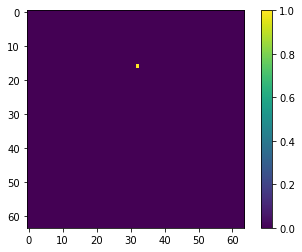

In [297]:
mip_z(v); plt.colorbar()

In [298]:

proj.shape

(64, 64)

In [299]:
v.shape

(64, 64, 64)